# Lecture 3: Feature Extraction with Python

In [18]:
%matplotlib inline
from torchvision import datasets

# Python Imaging Library (open, manipulate, save various image format).
import PIL 

# Local Binary Pattern - Visual Discriptor used in texture classification.
# graycomatrix - calculate gray-level co-occurrence matrix.
# graycoprops - calculate texture properties of a GLCM.
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops

# return real and imaginary responses to Gabor filter.
from skimage.filters import gabor

# serialization of deserialization.
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [19]:
train_dataset = datasets.CIFAR10('./cifar10', train = True, download = True)
test_dataset = datasets.CIFAR10('./cifar10', train = False, download = True)

In [20]:
# Size of training and testing dataset.
print('No. of samples in train set: '+str(len(train_dataset)))
print('No. of samples in train set: '+str(len(test_dataset)))

No. of samples in train set: 50000
No. of samples in train set: 10000


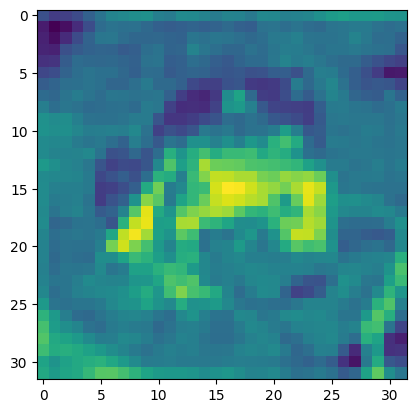

In [21]:
# Feature extraction on a single image
img = train_dataset[0][0]   # PIL image
img_gray = img.convert('L') # converting to grayscale
img_arr = np.array(img_gray)
plt.imshow(img_arr)

## Local Binary Pattern (LBP)

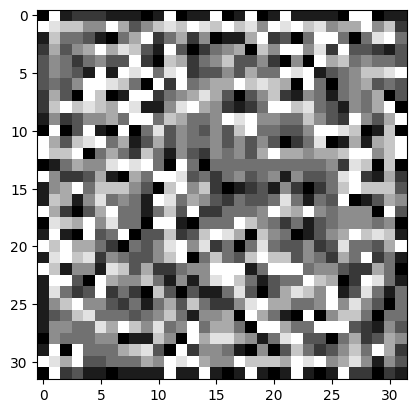

In [22]:
# Finding LBP

# parameters: image(2D grayscale image, No. of neighbour, Radius of circle, method).
feature_lbp = local_binary_pattern(img_arr, 8, 1, 'uniform')

# converting the feature into a unsigned 8 bit number.
feature_lbp = np.uint8((feature_lbp/feature_lbp.max())*255)
# Converting from array to PIL image.
lbp_image = PIL.Image.fromarray(feature_lbp)
plt.imshow(lbp_image, cmap='gray')

In [23]:
# Finding Energy and entropy from LBP feature.

lbp_histogram, _ = np.histogram(feature_lbp, 8)
lbp_histogram = np.array(lbp_histogram, dtype = float)
lbp_probability = np.divide(lbp_histogram, np.sum(lbp_histogram))
lbp_energy = np.sum(lbp_probability**2)
# Entropy H = - Σ (p(x) * log2(p(x))) 
# where "p(x)" represents the probability of occurrence of each unique value "x" 
lbp_entropy = -np.sum(np.multiply(lbp_probability, np.log2(lbp_probability)))

print('LBP energy = '+ str(lbp_energy))
print('LBP energy = '+ str(lbp_entropy))

LBP energy = 0.14315032958984375
LBP energy = 2.8972505530220363


## Co-occurance matrix

In [24]:
# Finding GrayLevel Co-occurence matrix (GLCM) from the co-occurence matrix.

gray_co_matrix = graycomatrix(img_arr, [2], [0], symmetric = True, normed = True)
contrast = graycoprops(gray_co_matrix, prop='contrast')
dissimilarity = graycoprops(gray_co_matrix, prop='dissimilarity')
homogeneity = graycoprops(gray_co_matrix, prop='homogeneity')
energy = graycoprops(gray_co_matrix, prop='energy')
correlation = graycoprops(gray_co_matrix, prop='correlation')

print('Contrast = ' + str(contrast))
print('dissimilarity = ' + str(dissimilarity))
print('homogeneity = ' + str(homogeneity))
print('energy = ' + str(energy))
print('correlation = ' + str(correlation))

Contrast = [[1296.89166667]]
dissimilarity = [[24.225]]
homogeneity = [[0.06323756]]
energy = [[0.02728292]]
correlation = [[0.61196184]]


## Gabor filter

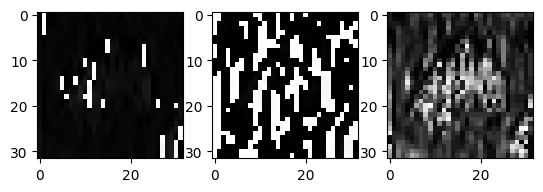

In [25]:
# gabor filter
gabor_filter_real, gabor_filter_imaginary = gabor(img_arr, frequency=0.6)
gabor_filter = (gabor_filter_real**2+gabor_filter_imaginary**2)//2

# Displapy the filter response
fig, ax = plt.subplots(1, 3)
ax[0].imshow(gabor_filter_real, cmap='gray')
ax[1].imshow(gabor_filter_imaginary, cmap='gray')
ax[2].imshow(gabor_filter, cmap='gray')

In [26]:
# Energy and Entropy of Gabor Filter response.
gabor_histogram, _ = np.histogram(gabor_filter, 8)
gabor_histogram = np.array(gabor_histogram, dtype=float)
gabor_probability = np.divide(gabor_histogram, np.sum(gabor_histogram))
gabor_energy = np.sum(gabor_probability**2)
gabor_entropy = -np.sum(np.multiply(gabor_probability, np.log2(gabor_probability)))
print('Gabour Energy = '+str(gabor_energy))
print('Gabour Entropy = '+str(gabor_entropy))

Gabour Energy = 0.24701309204101562
Gabour Entropy = 2.3533467655293547


## Extracting features from all images in the training dataset

In [27]:
label = []
# lbp(2) + glcm(5) + gabor_filter(2)
feature_length = 2 + 5 + 2
train_features = np.zeros((len(train_dataset), feature_length)) # Feature vector

for tr in tqdm(range(len(train_dataset))):
  img = train_dataset[tr][0]   # PIL image
  img_gray = img.convert('L') # converting to grayscale
  img_arr = np.array(img_gray.getdata()).reshape(img.size[0],img.size[1]) # Converting to array

  #local binary pattern
  feature_lbp = local_binary_pattern(img_arr, 5, 2, 'uniform').reshape(img.size[0],img.size[1])
  lbp_histogram, _ = np.histogram(feature_lbp, 8)
  lbp_histogram = np.array(lbp_histogram, dtype = float)
  lbp_probability = np.divide(lbp_histogram, np.sum(lbp_histogram))
  lbp_energy = np.nansum(lbp_probability**2)
  lbp_entropy = -np.nansum(np.multiply(lbp_probability, np.log2(lbp_probability)))

  #GrayLevel Co-occurence Matrix
  gray_co_matrix = graycomatrix(img_arr, [2], [0], 256, symmetric = True, normed = True)
  contrast = graycoprops(gray_co_matrix, prop='contrast')
  dissimilarity = graycoprops(gray_co_matrix, prop='dissimilarity')
  homogeneity = graycoprops(gray_co_matrix, prop='homogeneity')
  energy = graycoprops(gray_co_matrix, prop='energy')
  correlation = graycoprops(gray_co_matrix, prop='correlation')
  gclm_features = np.array([contrast[0][0], dissimilarity[0][0], homogeneity[0][0], energy[0][0], correlation[0][0]])

  #Gabor Filter 
  gabor_filter_real, gabor_filter_imaginary = gabor(img_arr, frequency=0.6)
  gabor_filter = (gabor_filter_real**2 + gabor_filter_imaginary**2)//2
  gabor_histogram, _ = np.histogram(gabor_filter, 8)
  gabor_histogram = np.array(gabor_histogram, dtype = float)
  gabor_probability = np.divide(gabor_histogram, np.sum(gabor_histogram))
  gabor_energy = np.nansum(gabor_probability**2)
  gabor_entropy = -np.nansum(np.multiply(gabor_probability, np.log2(gabor_probability)))

  # Contatinating features (2+5+2)
  concatinated_features = np.concatenate(([lbp_energy, lbp_entropy], gclm_features, [gabor_energy, gabor_entropy]), axis = 0)
  train_features[tr,:] = concatinated_features

  # Class label
  label.append(train_dataset[tr][1])
train_label = np.array(label)

  0%|          | 0/50000 [00:00<?, ?it/s]/tmp/ipykernel_93529/2692255414.py:17: RuntimeWarning: divide by zero encountered in log2
  lbp_entropy = -np.nansum(np.multiply(lbp_probability, np.log2(lbp_probability)))
/tmp/ipykernel_93529/2692255414.py:17: RuntimeWarning: invalid value encountered in multiply
  lbp_entropy = -np.nansum(np.multiply(lbp_probability, np.log2(lbp_probability)))
/tmp/ipykernel_93529/2692255414.py:35: RuntimeWarning: divide by zero encountered in log2
  gabor_entropy = -np.nansum(np.multiply(gabor_probability, np.log2(gabor_probability)))
/tmp/ipykernel_93529/2692255414.py:35: RuntimeWarning: invalid value encountered in multiply
  gabor_entropy = -np.nansum(np.multiply(gabor_probability, np.log2(gabor_probability)))
100%|██████████| 50000/50000 [01:56<00:00, 427.93it/s]


In [28]:
label = []
# lbp(2) + glcm(5) + gabor_filter(2)
test_features = np.zeros((len(test_dataset), feature_length)) # Feature vector

for ts in tqdm(range(len(test_dataset))):
  img = test_dataset[ts][0]   # PIL image
  img_gray = img.convert('L') # converting to grayscale
  img_arr = np.array(img_gray.getdata()).reshape(img.size[0],img.size[1]) # Converting to array

  #local binary pattern
  feature_lbp = local_binary_pattern(img_arr, 5, 2, 'uniform').reshape(img.size[0],img.size[1])
  lbp_histogram, _ = np.histogram(feature_lbp, 8)
  lbp_histogram = np.array(lbp_histogram, dtype = float)
  lbp_probability = np.divide(lbp_histogram, np.sum(lbp_histogram))
  lbp_energy = np.nansum(lbp_probability**2)
  lbp_entropy = -np.nansum(np.multiply(lbp_probability, np.log2(lbp_probability)))

  #GrayLevel Co-occurence Matrix
  gray_co_matrix = graycomatrix(img_arr, [2], [0], 256, symmetric = True, normed = True)
  contrast = graycoprops(gray_co_matrix, prop='contrast')
  dissimilarity = graycoprops(gray_co_matrix, prop='dissimilarity')
  homogeneity = graycoprops(gray_co_matrix, prop='homogeneity')
  energy = graycoprops(gray_co_matrix, prop='energy')
  correlation = graycoprops(gray_co_matrix, prop='correlation')
  gclm_features = np.array([contrast[0][0], dissimilarity[0][0], homogeneity[0][0], energy[0][0], correlation[0][0]])

  #Gabor Filter 
  gabor_filter_real, gabor_filter_imaginary = gabor(img_arr, frequency=0.6)
  gabor_filter = (gabor_filter_real**2 + gabor_filter_imaginary**2)//2
  gabor_histogram, _ = np.histogram(gabor_filter, 8)
  gabor_histogram = np.array(gabor_histogram, dtype = float)
  gabor_probability = np.divide(gabor_histogram, np.sum(gabor_histogram))
  gabor_energy = np.nansum(gabor_probability**2)
  gabor_entropy = -np.nansum(np.multiply(gabor_probability, np.log2(gabor_probability)))

  # Contatinating features (2+5+2)
  concatinated_features = np.concatenate(([lbp_energy, lbp_entropy], gclm_features, [gabor_energy, gabor_entropy]), axis = 0)
  test_features[ts,:] = concatinated_features

  # Class label
  label.append(test_dataset[ts][1])
test_label = np.array(label)

  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_93529/1922634228.py:16: RuntimeWarning: divide by zero encountered in log2
  lbp_entropy = -np.nansum(np.multiply(lbp_probability, np.log2(lbp_probability)))
/tmp/ipykernel_93529/1922634228.py:16: RuntimeWarning: invalid value encountered in multiply
  lbp_entropy = -np.nansum(np.multiply(lbp_probability, np.log2(lbp_probability)))
/tmp/ipykernel_93529/1922634228.py:34: RuntimeWarning: divide by zero encountered in log2
  gabor_entropy = -np.nansum(np.multiply(gabor_probability, np.log2(gabor_probability)))
/tmp/ipykernel_93529/1922634228.py:34: RuntimeWarning: invalid value encountered in multiply
  gabor_entropy = -np.nansum(np.multiply(gabor_probability, np.log2(gabor_probability)))
100%|██████████| 10000/10000 [00:22<00:00, 436.50it/s]


In [29]:
# Normalization of train feature to range [0, 1].
train_maxs = np.amax(train_features, axis=0)    # finding maxs along each column.
train_mins = np.amin(train_features, axis=0)    # finding mins along each column.
train_maxs_rep = np.tile(train_maxs, (50000, 1))    # repeating the maximum value along the rows.
train_mins_rep = np.tile(train_mins, (50000, 1))    # repeating the manimum value along the column.
train_features_normalized = np.divide(train_features-train_mins_rep, train_maxs_rep)

# Normalization of test features to range [0, 1]. 
test_maxs_rep = np.tile(train_maxs, (10000, 1))
test_mins_rep = np.tile(train_mins, (10000, 1))
test_features_normalized = np.divide(test_features - test_mins_rep, test_maxs_rep)

In [30]:
# Saving normalized training data and label.
with open("train_features.pckl", "wb") as f:
    pickle.dump(train_features_normalized, f)
with open("train_label.pckl", "wb") as f:
    pickle.dump(train_label, f)

# Saving normalized test data and label.
with open("test_features.pckl", "wb") as f:
    pickle.dump(test_features_normalized, f)
with open("test_label.pckl", "wb") as f:
    pickle.dump(test_label, f)

print('Files saved to Disk!')

Files saved to Disk!
